In [1]:
# Importing Libraries
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# Establishing connection with google drive
# from google.colab import drive
# drive.mount('/content/drive')
import os
color_dataset_path = 'EuroSAT'  # Base path for colorised images
gray_scale_dataset_path = 'EuroSAT_gray_scale'  # Base path for grayscale images
if not os.path.exists(gray_scale_dataset_path):
    os.makedirs(gray_scale_dataset_path)

# List of folders representing different classes
class_folders = ['River', 'SeaLake', 'Residential', 'Pasture', 'AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'PermanentCrop']

In [3]:
# Function to convert RGB Image to GrayScale
def convert_to_grayscale(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cv2.imwrite(output_path, gray_image)

In [4]:
# Convert all images to GrayScale
for folder in class_folders:
    source_folder = os.path.join(color_dataset_path, folder)
    dest_folder = os.path.join(gray_scale_dataset_path, f"{folder}_gray_scale")

    if not os.path.exists(source_folder):
        print(f"Warning: Source folder {source_folder} does not exist. Skipping...")
        continue

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for filename in os.listdir(source_folder):
        image_path = os.path.join(source_folder, filename)
        output_path = os.path.join(dest_folder, filename)
        convert_to_grayscale(image_path, output_path)

print("\nGrayscale conversion completed!")


Grayscale conversion completed!


In [5]:
# Function to load and preprocess images from directories
def load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64)):
    X = []  # Grayscale images
    Y = []  # Color images

    for folder in class_folders:
        color_folder = os.path.join(color_dataset_path, folder)
        gray_folder = os.path.join(gray_scale_dataset_path, f"{folder}_gray_scale")

        if not os.path.exists(color_folder) or not os.path.exists(gray_folder):
            print(f"Skipping missing folder: {color_folder} or {gray_folder}")
            continue

        # List all files in the color and grayscale folder
        color_files = os.listdir(color_folder)
        gray_files = os.listdir(gray_folder)

        for filename in color_files:
            color_path = os.path.join(color_folder, filename)
            gray_path = os.path.join(gray_folder, filename)

            if not os.path.isfile(color_path) or not os.path.isfile(gray_path):
                print(f"Skipping missing files: {color_path} or {gray_path}")
                continue

            color_img = cv2.imread(color_path)
            gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)

            if color_img is None or gray_img is None:
                print(f"Error loading images: {color_path} or {gray_path}")
                continue

            # Resize images to the desired size (128x128)
            color_img = cv2.resize(color_img, size)
            gray_img = cv2.resize(gray_img, size)

            # Expand dimensions of grayscale image to (height, width, 1)
            gray_img = np.expand_dims(gray_img, axis=-1)

            # Normalize pixel values to [0, 1]
            X.append(gray_img / 255.0)  # Grayscale images
            Y.append(color_img / 255.0)  # Color images

    return np.array(X), np.array(Y)

In [6]:
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate

# Define U-Net architecture for colorization
def build_colorization_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)  # 3 channels for RGB color

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
# Load and Split the data into training and validation sets
X, Y = load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64))
X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_val = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]

In [8]:
# Build and compile the model
input_shape = (64, 64, 1)  # (height, width, channels)
model = build_colorization_model(input_shape)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

In [9]:
# Train the model
try:
    history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

    # Save model weights with correct filename
    weights_path = '/content/drive/MyDrive/colorization_model_weights.weights.h5'
    model.save_weights(weights_path)
    print(f"Model weights saved successfully to {weights_path}.")

except Exception as e:
    print(f"Error during training: {e}")

Epoch 1/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 905s 668ms/step - accuracy: 0.7833 - loss: 0.0055 - val_accuracy: 0.7159 - val_loss: 0.0017
Epoch 2/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 911s 675ms/step - accuracy: 0.8178 - loss: 0.0011 - val_accuracy: 0.7287 - val_loss: 0.0015
Epoch 3/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 880s 652ms/step - accuracy: 0.8137 - loss: 0.0012 - val_accuracy: 0.7255 - val_loss: 0.0015
Epoch 4/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 834s 618ms/step - accuracy: 0.8198 - loss: 0.0010 - val_accuracy: 0.7297 - val_loss: 0.0013
Epoch 5/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 788s 584ms/step - accuracy: 0.8205 - loss: 0.0010 - val_accuracy: 0.7310 - val_loss: 0.0013
Error during training: [Errno 2] Unable to synchronously create file (unable to open file: name = '/content/drive/MyDrive/colorization_model_weights.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)


In [10]:
# Evaluate the model on the validation set and test accuracy
val_loss, val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.7647 - loss: 0.0012
Validation Loss: 0.0013027576496824622
Validation Accuracy: 0.7309809923171997


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


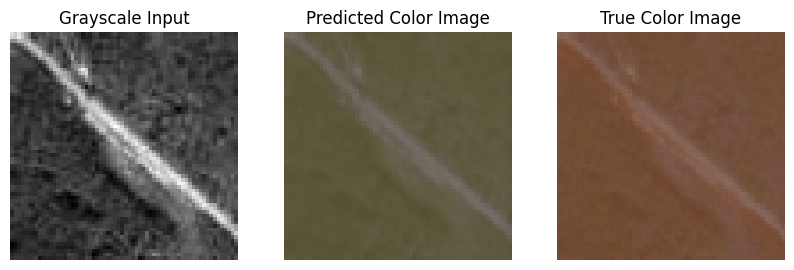

In [11]:
###### Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    # Get the grayscale input and actual color image
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]

    # Add batch dimension (1, 64, 64, 1) for model prediction
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()

# Test the model on one sample from validation set
test_model(model, X_val, Y_val, index=0)